# Standard Preamble

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import scipy.io as sio
import scipy.optimize as opt
import os
import glob
from scipy.stats import norm
import math
from scipy.stats import expon
# import arviz as az
# import pymc3 as pm
import pandas as pd
from datetime import datetime, timedelta
plt.rcParams.update({'font.size': 16})

# Define functions

In [ ]:
# want to create a load data function that combines dataframes and overwrites when necessary

In [30]:
def UniqueVals(stims, responses):
    
    """
    Takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    
    Inputs:
    stims = vector of all stimuli
    responses = vector of all responses
    
    Outputs:
    unique_stims = vector of the unrepeated stimulus locations
    Nstims = the number of times each unique stim was visited (vector)
    Kleft = the number of times the response was left at each stim location
    """
    
    unique_stims, stim_idx = np.unique(stims, return_index=True)
    unique_stims = stims[np.sort(stim_idx)]
    Nstims = []
    Kleft = []
    for u in unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return unique_stims, Nstims, Kleft

In [173]:
def nloglik(params,X,N,K):
    '''
    This function returns the negative log likelihood of the parameters mu and sigma 
    for a data set 
    X = stimuli (vector)
    N = number of trials at each X 
    K = Number of trials with the response of interest
    '''   
    alpha=params[0]
    beta=params[1]
    
    psi = norm.cdf(X,alpha,beta)       
    ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))

    nll = -ll
    
    return nll

In [184]:
def psiBIC(params, data):
    """
    Definition: calculates the bayesian information criteria (BIC) for a psychometric function 
    
    inputs:
    params = vector of the parameters for the psychometric function (alpha, beta), in this case, it only takes two arguments
    data = a list of size 3 containing 
        1) N = the number of trials at each stimulus location
        2) K = the number of 'left' responses at each stimulus location
        3) x = the stimulus locations
    
    outputs:
    BIC
    """   
    #Organize the data
    alpha = params[0]
    beta = params[1]
    N = data[0]
    K = data[1]
    x = data[2]
    
    #Calcualte the log likelihood    
    psi = norm.cdf(x,alpha,beta)
    ll = np.nansum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
    
    #Calculate BIC
    BIC = -2 * ll + np.log(len(N)) * len(params)
    
    return BIC

# Load the data

In [121]:
#Change the directory
os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_PSI')

#Load the data and combine
file_names = glob.glob("*.csv")
# combined_data = [pd.read_csv(i, parse_dates=['StartTime','TestLen']) for i in file_names]
combined_data = [pd.read_csv(i, parse_dates=['StartTime']) for i in file_names]

#Create data frame
DF = pd.concat(combined_data)

#Create groupby objects for easy indexing
grp_tests = DF.groupby(['SID','Test'])
grp_subjs = DF.groupby(['SID'])

# Confirmatory Analysis

## Are start positions close to equal?

In [36]:
for name, test in grp_tests:
    
    #Calculate the percept of start positions that started above
    started_above = sum(test.AllStarts > test.AllStims)
    above_prct = round((started_above/len(test))*100,1)

    #Print the results
    print(name[0]+name[1])
    print(str(above_prct) + '% of trials started above the stimulus position')

PSItest_28a
50.7% of trials started above the stimulus position
PSItest_28b
50.7% of trials started above the stimulus position


## Are the start and end speeds randomized?

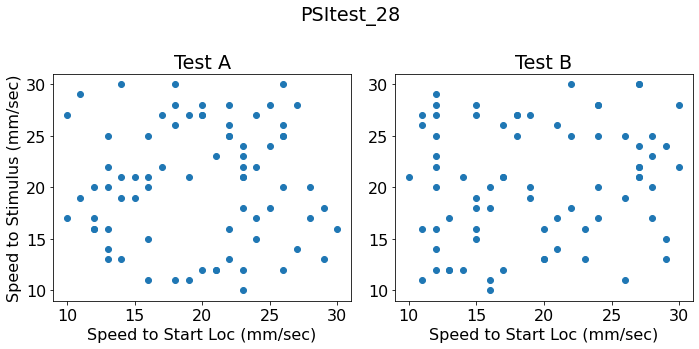

In [152]:
#Loop through all subejcts
for name, test in grp_subjs:
    
    #Index the different tests
    Test_a = test[test.Test=='a']
    Test_b = test[test.Test=='b']
    
    #Plot
    fig, ax = plt.subplots(1,2, figsize=(10,5),tight_layout=True)
    ax[0].plot(Test_a.StartSpeeds, Test_b.StimSpeeds,'o')
    ax[0].set(ylabel='Speed to Stimulus (mm/sec)', xlabel='Speed to Start Loc (mm/sec)', title='Test A')
    ax[1].plot(Test_b.StartSpeeds, Test_b.StimSpeeds,'o')
    ax[1].set(xlabel='Speed to Start Loc (mm/sec)', title='Test B')    
    fig.suptitle(name) 
    plt.show()    

## How much time between the tests, and how long is each test? 

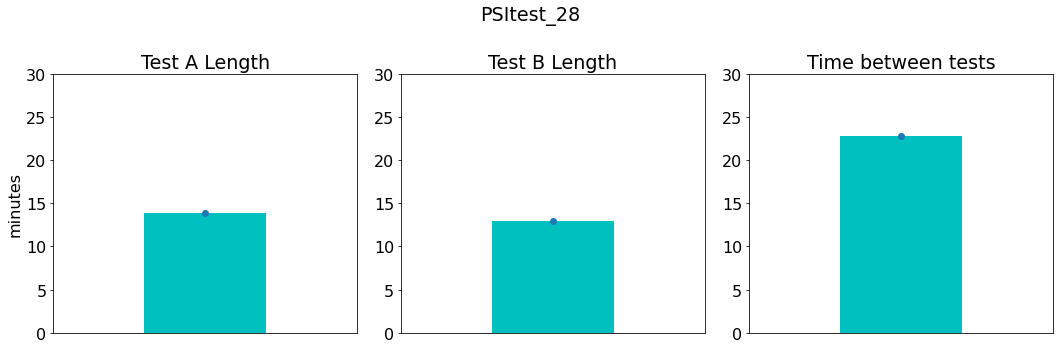

In [151]:
#Loop through all subejcts
all_td, a_len, b_len = [], [], []
for name, test in grp_subjs:
    
    #Index the different tests
    test_a = test[test.Test=='a']
    test_b = test[test.Test=='b']
    
    #calculate the length of each test
    a_len = np.append(a_len, test_a.TestLen[0]/60)
    b_len = np.append(b_len, test_b.TestLen[0]/60)

    #Calculate difference between tests and save
    test_a_end = test_a.StartTime[0] + timedelta(seconds=test_a.TestLen[0])
    time_diff = test_b.StartTime[0] - test_a_end
    all_td = np.append(all_td, time_diff.seconds/60)
    
    #Plot
    fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=True)
    ax[0].bar(0,np.mean(a_len),color='c')
    ax[0].plot(0,a_len,'o')
    ax[0].set(xlim=(-1,1), ylim=(0,30), ylabel='minutes', title='Test A Length',xticks=[])
    
    ax[1].bar(0,np.mean(b_len),color='c')
    ax[1].plot(0,b_len,'o')
    ax[1].set(xlim=(-1,1), ylim=(0,30), title='Test B Length',xticks=[])
    
    ax[2].bar(0,np.mean(all_td),color='c')
    ax[2].plot(0,all_td,'o')
    ax[2].set(xlim=(-1,1), ylim=(0,30), title='Time between tests',xticks=[])
    fig.suptitle(name) 
    plt.show()

## Are the pre-set simtuli appropriately distributed? DF

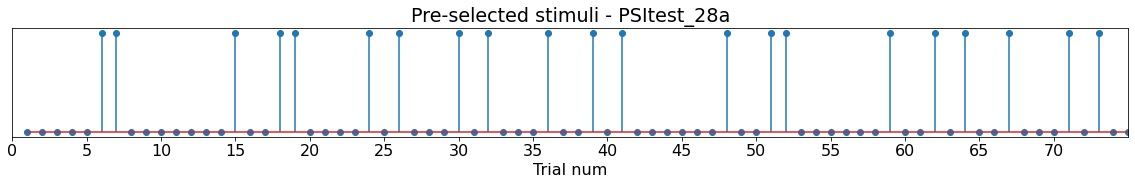

Largest difference between pre-selected stim =  8


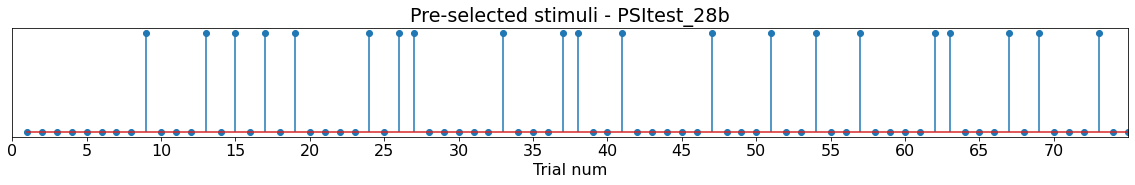

Largest difference between pre-selected stim =  6


In [150]:
for name, test in grp_tests:
    
    #Plot 
    fig, ax = plt.subplots(figsize=(20,2))
    ax.stem(test.Trial_num,test.SelectedStims)
    ax.set(xlim=(1,75), yticks=[], xticks=np.arange(0,75,5),title='Pre-selected stimuli - '+name[0]+name[1],xlabel='Trial num')
    plt.show()
    
    #Find the max difference between pre-selected stims
    max_diff = np.max(np.diff(test.Trial_num[test.SelectedStims==1]))
    print('Largest difference between pre-selected stim = ', max_diff) 


# Data Analysis 

## Plot the data for each test along with the psi function estimated and fit post-hoc

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_12440/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_12440/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_12440/3097947520.py:24: RuntimeWarning: divide by zero encountered in log
  ll = np.nansum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_12440/3097947520.py:24: RuntimeWarning: invalid value encountered in multiply
  ll = np.nansum(K * np.log(psi) + ((N - K) * np.log(1-psi)))


OverflowError: cannot convert float infinity to integer

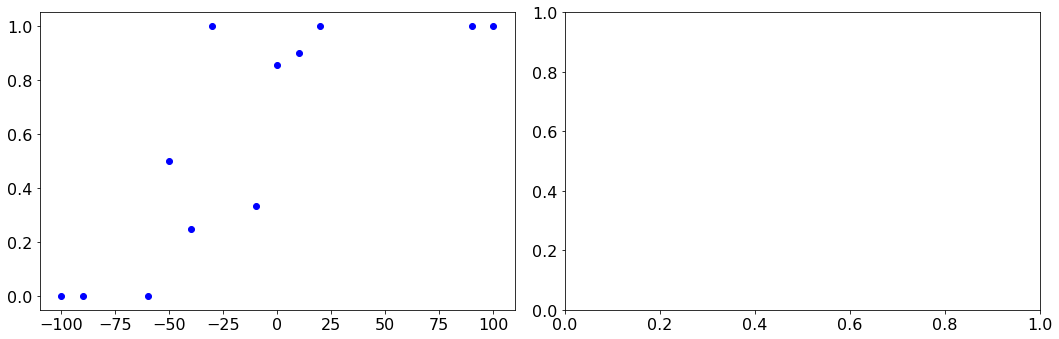

In [187]:
unique_tests = ['a','b']

for name, test in grp_subjs:
    
    fig, ax = plt.subplots(1,2,figsize=(15,5),tight_layout=True)
    for i, test_id_idx in enumerate(unique_tests):
        
        #Index the test
        current_test = test[test.Test==test_id_idx]

        #index all the stim positions
        BslDiff = round(current_test.BslDiff[0])
        x = np.unique(current_test.AllStims+BslDiff)
        
        #Calculate the PSI algorithm
        psi_est = norm.cdf(x,current_test.Alpha_EV.values[-1]+BslDiff,current_test.Beta_EV.values[-1])

        #Calculate unique values of the stims
        unique_stims, Nstims, Kleft = UniqueVals(current_test.AllStims.values+BslDiff, current_test.BinaryResponses.values)

        #Fit the psychometric function to the data
        params = opt.fmin(nloglik, x0=[np.random.rand(), np.random.rand()],
                          args=(unique_stims,Nstims,Kleft), disp=1, full_output=False, maxfun=1e6, xtol=1e-6)
        psi_fit = norm.cdf(x, params[0], params[1])
        
        #Calculate BIC
        BIC_est = psiBIC(params, [Nstims, Kleft, x])
        BIC_fit = psiBIC(params, [Nstims, Kleft, x])
    
        #Plot
        ax[i].plot(unique_stims, Kleft/Nstims, 'bo', label='Response data')
        ax[i].plot(x, psi_est, 'b', label='Psi algorithm est. (BIC='+str(round(BIC_est))+')', alpha=0.5)
        ax[i].plot(x, psi_fit, 'k--', label='Fitted Psi (BIC='+str(round(BIC_fit))+')')
        ax[i].set(title='Test ' + test_id_idx)
        ax[i].legend()
        
    fig.suptitle(name) 
    plt.show()